In [142]:
import numpy as np
import matplotlib.pyplot as plt
import interneuron_amb
import stellate
from scipy import signal,optimize,stats
import phase_prec_hf as hf_p
import seaborn as sns
import sim_utils as s_utils
from neuron import h

h.load_file("stdrun.hoc")
h.celsius = 37
h.cvode.active(1)

import importlib
import analysis_utils as a_utils
importlib.reload(interneuron_amb)
importlib.reload(stellate)

<module 'stellate' from '/home/govind/gov_semproject/GridCellsTheta/GridCellsCond/stellate.py'>

In [ ]:
stellate_0 = stellate.Stellate(0)
global_intrnrn = interneuron_amb.Interneuron(1)

gs_weight = 0.3
gs_inh_gmax = 1e-3  # uS
sg_weight = 1.0
sg_exc_gmax = 5e-4  # uS

nc_gs = h.NetCon(global_intrnrn.soma(0.5)._ref_v, stellate_0.inhb_syn, sec=global_intrnrn.soma)
nc_gs.weight[0] = gs_weight * gs_inh_gmax 

nc_sg = h.NetCon(stellate_0.soma(0.5)._ref_v, global_intrnrn.exc_syn, sec=stellate_0.soma)
nc_sg.weight[0] = sg_weight * sg_exc_gmax


# ---------------- theta drive to interneuron ----------------
theta_ic = h.IClamp(global_intrnrn.soma(0.5))
theta_ic.dur = 1e9

freq = 10
time_ms = 20000
osc_amp = 2e-3
baseline_amp = 5e-4

T, num_steps = time_ms/1000, time_ms


# ---------------- stellate drive ----------------
stell_ic = h.IClamp(stellate_0.soma(0.5))
stell_ic.dur = 1e9  

baseline_stell = -5e-3
init_phase = np.pi/2

str_input, end_input = 2000,8000
peak_t = (end_input + str_input) / 2
ds_inh = 5e-5


# ---------------- time axis ----------------
dt = 1.0  # ms
h.dt = dt

time_arr = np.arange(0, time_ms, dt)


# ---------------- stellate input waveform ----------------
stell_arr = np.full_like(time_arr, baseline_stell)

sigma = 1200  # ms width

dsinhb_arr = (ds_inh - baseline_stell) * np.exp(
    -(time_arr[str_input:end_input] - peak_t)**2 / (2 * sigma**2)
)

linear_disinhb_arr = baseline_stell + (ds_inh - baseline_stell) * (
    (time_arr[str_input:end_input] - str_input) / (end_input - str_input)
)


stell_arr[str_input:end_input] = dsinhb_arr + baseline_stell
#stell_arr[str_input:end_input] = linear_disinhb_arr

stell_vec = h.Vector(stell_arr)
stell_vec.play(stell_ic._ref_amp, h.dt)


# ---------------- theta oscillation waveform ----------------
curr_arr = osc_amp * np.sin(2 * np.pi * freq * time_arr / 1000) + np.full_like(time_arr, baseline_amp)

curr_vec = h.Vector(curr_arr)
curr_vec.play(theta_ic._ref_amp, h.dt)


# ---------------- spike recording ----------------
spike_times_stell = h.Vector()
spike_times_intrnrn = h.Vector()

nc_stell = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
nc_stell.threshold = 0
nc_stell.record(spike_times_stell)

nc_intrnrn = h.NetCon(global_intrnrn.soma(0.5)._ref_v, None, sec=global_intrnrn.soma)
nc_intrnrn.threshold = 0
nc_intrnrn.record(spike_times_intrnrn)


0.0

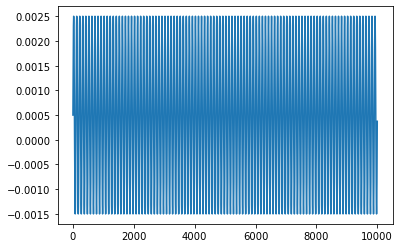

In [257]:
plt.plot(time_arr, curr_arr)

134733


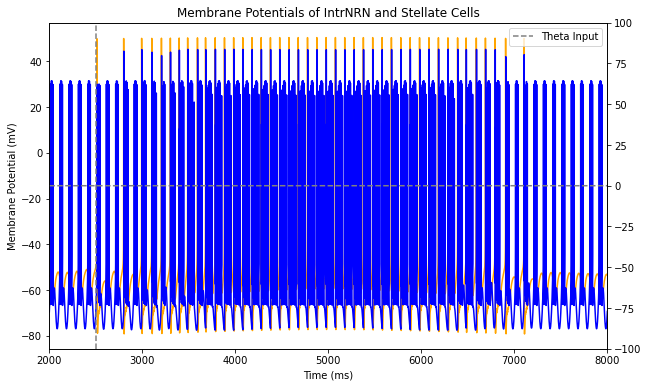

In [258]:
i_theta = h.Vector().record(theta_ic._ref_amp)
stell_input = h.Vector().record(stell_ic._ref_amp)
stellate_gh_vec = h.Vector().record(stellate_0.soma(0.5).stellate_mech._ref_gh)
stellate_v = h.Vector().record(stellate_0.soma(0.5)._ref_v)
global_intrnrn_v = h.Vector().record(global_intrnrn.soma(0.5)._ref_v)
time = h.Vector().record(h._ref_t)


h.finitialize(-65)
h.continuerun(10000)
print(len(time.to_python()))
fig,ax = plt.subplots(figsize=(10,6))
ax1 = ax.twinx()
ax1.plot(time,i_theta.to_python(), color='gray', linestyle='--', label='Theta Input')
ax.plot(time, stellate_v, label='Stellate',color='orange')
ax.plot(time, global_intrnrn_v, label='Global IntrNRN',color='blue')
##ax1.eventplot(spike_times, lineoffsets=-80, colors='r', linelengths=5, label='Stellate Spikes')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane Potential (mV)')
ax.set_title('Membrane Potentials of IntrNRN and Stellate Cells')
plt.legend()
plt.ylim(-100,100)
plt.xlim(str_input,end_input)
plt.axvline(x=2500, color='gray', linestyle='--')
plt.show()



In [239]:
print(len(time_arr))


10000


In [260]:
stell_spike_phases = freq * 2* np.pi * (np.array(spike_times_stell.to_python())/1000)%(2*np.pi)
intrnrn_spike_phases = freq * 2* np.pi * (np.array(spike_times_intrnrn.to_python())/1000)%(2*np.pi)

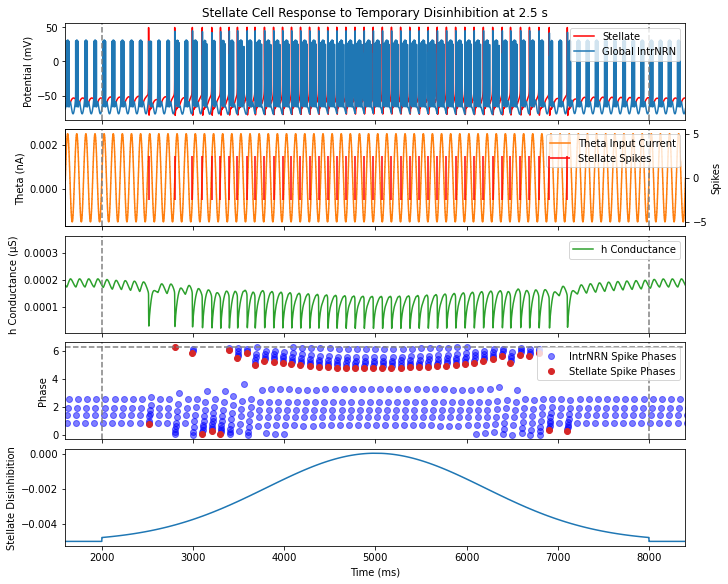

In [261]:
%matplotlib inline
fig, ax = plt.subplots(5, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

ax01 = ax[1].twinx()

# ---- Plots ----
ax[0].plot(time, stellate_v, color='r', label='Stellate')
ax[0].plot(time, global_intrnrn_v, label='Global IntrNRN')

ax[1].plot(time, i_theta.to_python(), color='C1', label='Theta Input Current')
ax01.eventplot(spike_times_stell, lineoffsets=0, colors='r',
               linelengths=5, label='Stellate Spikes')

ax[2].plot(time, stellate_gh_vec.to_python(), color='C2', label='h Conductance')

ax[3].plot(spike_times_intrnrn.to_python(), intrnrn_spike_phases, 'o',
           color='blue', alpha=0.5, label='IntrNRN Spike Phases')
ax[3].plot(spike_times_stell.to_python(), stell_spike_phases, 'o',
           color='C3', label='Stellate Spike Phases')

ax[4].plot(time, stell_input.to_python(), label='Stellate Disinhibition')

# ---- Vertical markers ----
for i in range(4):
    ax[i].axvline(str_input, color='gray', linestyle='--')
    ax[i].axvline(end_input, color='gray', linestyle='--')

# ---- Limits ----
for a in ax:
    a.set_xlim(str_input - 400, end_input + 400)

# ---- Reference line ----
ax[3].axhline(2*np.pi, color='gray', linestyle='--')

# ---- Labels ----
ax[0].set_ylabel('Potential (mV)')
ax[1].set_ylabel('Theta (nA)')
ax01.set_ylabel('Spikes')
ax[2].set_ylabel('h Conductance (µS)')
ax[3].set_ylabel('Phase')
ax[4].set_ylabel('Stellate Disinhibition')
ax[4].set_xlabel('Time (ms)')

# ---- Legends (merge ax[1] + ax01) ----
lines1, labels1 = ax[1].get_legend_handles_labels()
lines2, labels2 = ax01.get_legend_handles_labels()
ax[1].legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax[0].legend(loc='upper right')
ax[2].legend(loc='upper right')
ax[3].legend(loc='upper right')

# ---- Title ----
ax[0].set_title('Stellate Cell Response to Temporary Disinhibition at 2.5 s')

# ---- Save ----
plt.savefig(
    'stellate_response_dsinhb_gaussian_ramp.png',
    dpi=300,
    facecolor='white',
    edgecolor='white',
    transparent=False
)

plt.show()


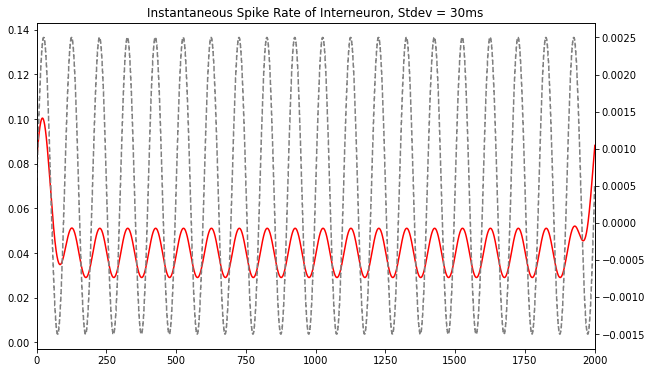

In [225]:
import analysis_utils as a_utils

spike_times_intrnrn_np = np.array(spike_times_intrnrn.to_python())
spike_rate = a_utils.instant_rate(spike_times_intrnrn_np,10000,30)
fig,ax = plt.subplots(figsize=(10,6))
ax2 = ax.twinx()
ax.plot(time_arr, spike_rate, color='red', label='Spike Rate')
ax2.plot(np.array(time), i_theta.to_python(), color='gray', linestyle='--', label='Theta Input')
plt.title("Instantaneous Spike Rate of Interneuron, Stdev = 30ms")
plt.xlim(0,2000)
plt.show()

NameError: name 'spike_times' is not defined

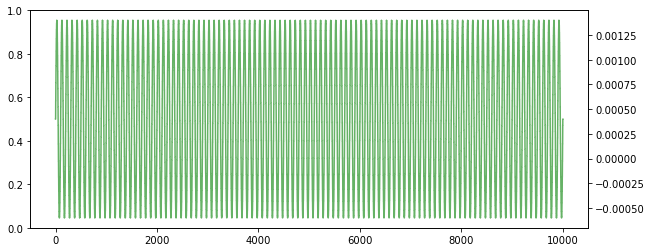

In [61]:
fig, ax = plt.subplots(figsize=(10, 4))
ax1 = ax.twinx()

ax1.plot(time, i_theta.to_python(), color='g', alpha=0.6)
ax.eventplot(spike_times, lineoffsets=0, colors='blue', linelengths=5)
ax.set_xlabel('Time (ms)')
ax.set_title('Step up stellate drive at 2.5s')
ax.set_xlim(2000,4000)
ax.axvline(x=2500, color='gray', linestyle='--')
#ax.axvline(x=3500, color='gray', linestyle='--')
plt.savefig("save_figs/theta_spk_times_step_0.png")
plt.show()

    

[0.42509383 0.88948714 1.55637692 2.32518757 3.26376167 4.52765729
 5.44531323 6.21947926 0.67774283 1.40726955 2.17443256 3.06603409
 4.32731039 5.28233659 6.06420846 0.52436039 1.25094006 2.00409287
 2.85567128 4.07338232 5.12817476 5.93118388 0.18134944 5.77641582
 5.14728975 4.64112539 4.28056904 4.07430294 3.95649115 3.90754903
 3.89439843 3.8913543  3.86363558 3.87938856 3.8848939  3.87357278
 3.89557489 3.91696356 3.89841682 3.89838    3.90739096 3.89656746
 3.87781072 3.86713121 3.84962591 3.85966448 3.85371334 3.85972584
 3.85693522 3.85068178 3.84080502 3.83721388 3.86055983 3.86985951
 3.87163955 3.85677455 3.84079022 3.83997742 3.83708276 3.84963892
 3.84815145 3.86360152 3.87718221 3.86923786 3.87449282 3.85467299
 3.84961781 3.85076177 3.84543242 3.88023962 3.87348593 3.86428511
 3.86054526 3.85682869 3.83136856 3.88131192 3.8669741  3.85102035
 3.84759074 3.84809126 3.8444526  3.82892975 3.84324264 3.83402348
 3.84932175 3.84933063 3.85072207 3.84251957 3.84219864 3.8372

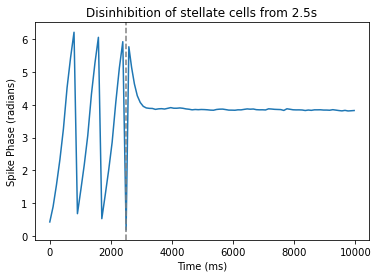

In [372]:
spike_phases = freq * 2* np.pi * (np.array(spike_times.to_python())/1000)%(2*np.pi)
print(spike_phases)
plt.plot(spike_times.to_python(),spike_phases)
plt.axvline(x=2500, color='gray', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Phase (radians)')
plt.title("Disinhibition of stellate cells from 2.5s")
#plt.axvline(x=3500, color='gray', linestyle='--')
plt.savefig('save_figs/phase_prec_step_sig_0.png',dpi=300)
plt.show()



[-0.01566036 -0.01560128 -0.01554288 ... -0.009499   -0.00951315
 -0.00953887]


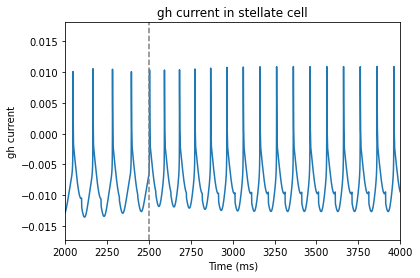

In [368]:

stell_gh_arr = np.array(stellate_gh_vec.to_python())
print(stell_gh_arr)
time_arr = np.array(time.to_python())
plt.plot(time_arr, stell_gh_arr)
plt.xlabel('Time (ms)')
plt.ylabel('gh current')
plt.title('gh current in stellate cell')
plt.xlim(2000,4000)
plt.axvline(x=2500, color='gray', linestyle='--')
plt.show()
#plt.axvline(x=3500, color='gray', linestyle='--')


[2.51823633 2.68161184 2.77580959 2.82329123 2.85740896 2.93602712
 3.02632597 3.123043   3.25052678 3.4159589  3.4651622 ]


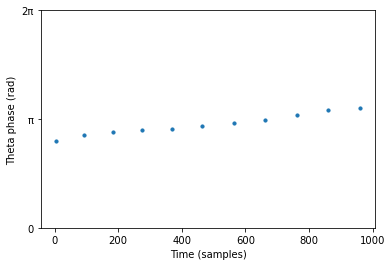

In [216]:
def vectorized_convert_angle(angles):
    return np.mod(angles, 2 * np.pi)

def calc_phase_single_stell(spike_idx, theta_signal):


    spike_idx = np.asarray(spike_idx)
    spike_idx = spike_idx[(spike_idx >= 0) & (spike_idx < len(theta_signal))]
    spike_idx = np.round(spike_idx).astype(int)

    analytic_signal = signal.hilbert(-np.array(theta_signal))
    instantaneous_phase = np.angle(analytic_signal)
    """
    Parameters
    ----------
    spike_idx : array-like
        Spike indices (NOT times)
    theta_signal : array-like
        Band-limited theta signal

    Returns
    -------
    spike_idx : np.ndarray
        Spike indices
    spike_phases : np.ndarray
        Theta phase at spike times in [0, 2π)
    """
    spike_phases = vectorized_convert_angle(
        instantaneous_phase[spike_idx]
    )

    return spike_idx, spike_phases

spike_idx, spike_phases = calc_phase_single_stell(
    spike_idx=spike_times,      # indices
    theta_signal=i_theta         # theta current
)
print(spike_phases)
first_phase = spike_phases[0]

plt.figure()
plt.scatter(spike_idx, spike_phases, s=10)
plt.xlabel("Time (samples)")
plt.ylabel("Theta phase (rad)")
plt.yticks([0, np.pi, 2*np.pi], ['0', 'π', '2π'])
plt.show()



[1.57079633 1.78977602 1.96037251 2.05470335 2.22284035 2.41945401
 2.63841251 2.86707392 3.10565839 3.31041335 3.59539187 3.84014694]


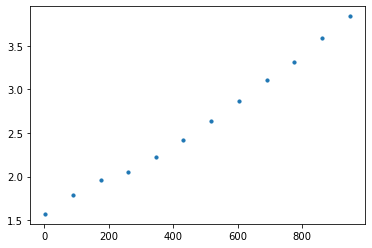

In [90]:
spike_arr = np.array(spike_times.to_python())
spike_idx = np.array(spike_arr).astype(int)

analytic_signal = signal.hilbert(-i_theta)
instantaneous_phase = np.angle(analytic_signal)
stell_phase = vectorized_convert_angle(instantaneous_phase)
print(stell_phase[spike_idx])
plt.scatter(spike_idx, stell_phase[spike_idx], s=10)




In [140]:
theta = i_theta.to_python()

print(type(theta))
print(np.asarray(theta).shape)
print(theta)

<class 'list'>
(15224,)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878

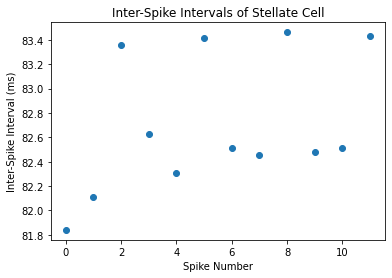

In [152]:
isi_array = np.diff(spike_times.to_python())    
plt.scatter(range(len(isi_array)), isi_array)
plt.xlabel('Spike Number') 
plt.ylabel('Inter-Spike Interval (ms)')
plt.title('Inter-Spike Intervals of Stellate Cell')
plt.show()                         

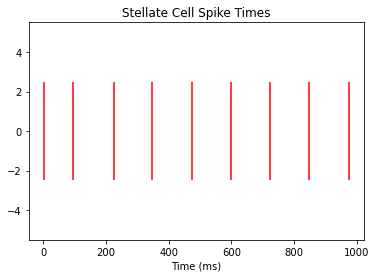

In [7]:
plt.eventplot(spike_times, lineoffsets=0, colors='r', linelengths=5)
plt.xlabel('Time (ms)')
plt.title('Stellate Cell Spike Times')
plt.show()

In [ ]:
stell_spikes_l = spike_times